In [1]:
#May 25
"""
Using 'm' for stellar mass / M_o, and 'M' for halo mass / M_o
"""

import ares
import numpy as np
import matplotlib.pyplot as pl

In [2]:
pop_halo = ares.populations.HaloPopulation()
data = ares.analysis.GalaxyPopulation() #for lit values

### DPL SMF relation  
Following from Moster2010  

$\phi ~[~/(Mpc)^3 dex^{-1}] = \frac{dM}{dlog(m(M))} \cdot \frac{dn}{dM}$  
Where $\frac{m(M)}{M} = r$ comes from Equ. 2  
The derivative has been found 2 ways, analytically in dlogm_dM(), and with finite differences in finite_dif(). 
The new x axis is then calcuated from the halo masses by:  $m = 10^{log_{10}(r) + log_{10}(haloMass)}$

I'm not totally convinced the smaller curvature is right, but it looks decent now.

In [3]:
# derivative of m(M) wrt M
def dm_dM(pop_halo, N, M_1, beta, gamma, mM_ratio):
    n2 = (-beta)*(pop_halo.halos.tab_M**(-beta-1)/M_1**(-beta)) + gamma*(pop_halo.halos.tab_M**(gamma-1)/M_1**(gamma))
    
    dydx = mM_ratio - pop_halo.halos.tab_M * 2 * N * n2 * ( (pop_halo.halos.tab_M/M_1)**(-beta) + \
                                                            (pop_halo.halos.tab_M/M_1)**(gamma) )**(-2) 

    return dydx

#derivative of log10( m ) wrt M
def dlogm_dM(pop_halo, N, M_1, beta, gamma, mM_ratio):
    
    dydx = -1* ((gamma-1)*(pop_halo.halos.tab_M/M_1)**(gamma+beta) - beta - 1) / (np.log(10)*pop_halo.halos.tab_M*((pop_halo.halos.tab_M/M_1)**(gamma+beta) + 1))

    return dydx

# finite difference of log10( m ) wrt M
def finite_dif(mM_ratio):
    m = mM_ratio + np.log10(pop_halo.halos.tab_M) # stellMass = ratio*haloMass
    diff = []
    for i in range(len(mM_ratio)-1):
        diff.append( (m[i+1] - m[i])/(pop_halo.halos.tab_M[i+1] - pop_halo.halos.tab_M[i]) )
    return diff

In [4]:
#double power law
def SMF_Moster2010(z, pop_halo, N, M_1, beta, gamma, diff=False):
    
    k = np.argmin(np.abs(z - pop_halo.halos.tab_z))
    
    mM_ratio = np.log10( 2*N / ( (pop_halo.halos.tab_M/M_1)**(-beta) + (pop_halo.halos.tab_M/M_1)**(gamma) ) )#equ 2
    
    """
    tab_dndm (halo) -> dndlog(m) (SM)
    need: tab_dndm / d(log(ratio)/dM
    """
    
    #to try either the analytic or finite derivative
    if diff:
        SMF = pop_halo.halos.tab_dndm[k, :][:-1] / finite_dif(mM_ratio)
    else:
        SMF = pop_halo.halos.tab_dndm[k, :] / dlogm_dM(pop_halo, N, M_1, beta, gamma, mM_ratio) #dn/dM / d(log10(m))/dM
#     SMF = pop_halo.halos.tab_dndm[k, :] * mM_ratio #HMF * m/M

    return SMF,  mM_ratio

# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Shifting stellar masses by 0.25 dex (Chabrier -> Salpeter) for source=stefanon2017
# Shifting stellar masses by 0.25 dex (Chabrier -> Salpeter) for source=duncan2014


C:\Users\Emma\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


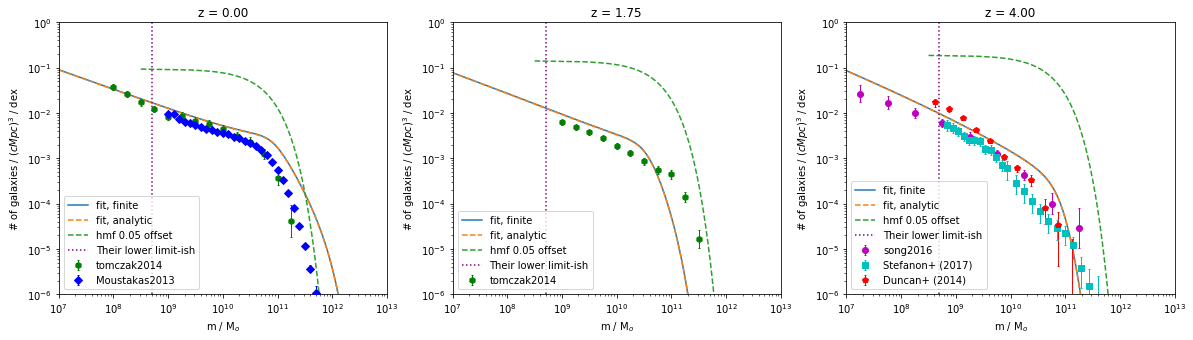

In [9]:
fig, axs = pl.subplots(1, 3, figsize=(20, 5))

#From Moster2010, table 1
N = [0.02820, 0.012, 0.03]
M_1 = 10**11.884 #np.exp(11.884)
beta = 1.057
gamma = 0.556

for i, z in enumerate([0, 1.75, 4]):
   
    #plot lit values
    data.PlotSMF(z=z, round_z=0.4, ax=axs[i])
    
    #get z index for halo mass array
    zz = np.argmin(np.abs(z - pop_halo.halos.tab_z))

    
    SMF, r = SMF_Moster2010(z, pop_halo, N[i], M_1, beta, gamma, True)
    SMF_a, r = SMF_Moster2010(z, pop_halo, N[i], M_1, beta, gamma)

    #get new x axis coords in stellar mass
    Sm_off = np.linspace(10**8.5, 10**12.5, num=len(pop_halo.halos.tab_dndm[zz, :]))
    
#     SM_a = np.linspace(10**8.5, 10**11.85, num=len(SMF_a))
#     SM = np.logspace(8.5, 11.85, num=len(SMF))
#     SM_a = pop_halo.halos.tab_M/r

    #using equ 2 to get the new stellar masses
    Sm = 10**(r + np.log10(pop_halo.halos.tab_M))[:-1]
    Sm_a = 10**(r + np.log10(pop_halo.halos.tab_M))

    #plotting
    axs[i].loglog(Sm, SMF, label='fit, finite')
    axs[i].loglog(Sm_a, SMF_a, label='fit, analytic', ls="--")
    
    #plotting just offset HMF for comparison
    axs[i].loglog(Sm_off, pop_halo.halos.tab_dndm[zz, :]*0.05, ls = "--", label='hmf 0.05 offset')

    axs[i].set_title("z = %.2f" %z)
    axs[i].set(xlabel='m / M$_o$', ylabel='# of galaxies / $ (cMpc)^3$ / dex')
    axs[i].set_ylim(1e-6, 1e0)
#     axs[i].set_xlim(-35, 0)
    axs[i].axvline(10**(8.7), color="purple", label="Their lower limit-ish", ls=":")
    axs[i].legend()

pl.show()

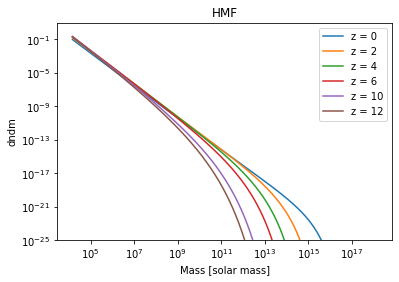

In [12]:
#checking HMF form
for z in [0, 2, 4, 6, 10, 12]:
    i = np.argmin(np.abs(z - pop_halo.halos.tab_z))
    pl.loglog(pop_halo.halos.tab_M, pop_halo.halos.tab_dndm[i, :]*0.05, label='z = %i' %z)
    
pl.legend()
pl.ylabel('dndm')
pl.xlabel('Mass [solar mass]')
pl.title('HMF')

pl.ylim(1e-25, 10)
pl.show()

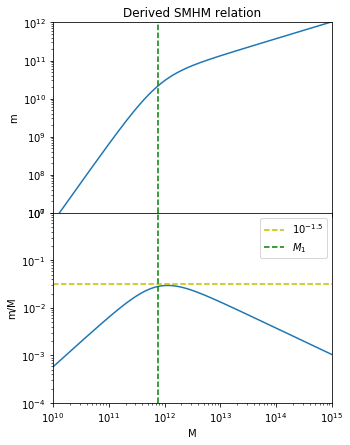

In [10]:
#looking at the SHM ratio m/M  - matches Fig 4

N = 0.02820
M_1 = 10**11.884 #np.exp(11.884)
beta = 1.057
gamma = 0.556

SMF, r = SMF_Moster2010(z, pop_halo, N, M_1, beta, gamma) #* pop_halo.halos.tab_M
ratio = 10**(r)
SM = pop_halo.halos.tab_M

fig, axs = pl.subplots(2, 1, figsize=(5, 7), sharex=True)
pl.subplots_adjust(hspace=0)
i = 0

axs[i].set_title("Derived SMHM relation")
axs[i].loglog(SM, ratio*pop_halo.halos.tab_M)#, label='c = %.e' %c)

axs[i].set(ylabel='m')
axs[i].set_ylim(1e7, 1e12)
axs[i].set_xlim(1e10, 1e15)
axs[i].axvline(M_1, color="g", label="M_1", ls="--")

i = 1
axs[i].loglog(SM, ratio)#, label='c = %.e' %c)

axs[i].set(xlabel='M', ylabel='m/M')
axs[i].set_ylim(1e-4, 1e0)
axs[i].set_xlim(1e10, 1e15)
axs[i].axhline(10.0**(-1.5), color="y", label="$10^{-1.5}$", ls="--")
axs[i].axvline(M_1, color="g", label="$M_1$", ls="--")

axs[i].legend()

pl.show()

Seperating the double power law so the behavior of each exponent can be seen.

In [13]:
#only beta - low mass behavior
def SMF_b(z, pop_halo, N, M_1, beta):
    
    k = np.argmin(np.abs(z - pop_halo.halos.tab_z))
    
    mM_ratio = np.log10(2*N / ( (pop_halo.halos.tab_M/M_1)**(-beta)) ) #equ 2
    
    SMF = pop_halo.halos.tab_dndm[k, :] / dlogm_dM(pop_halo, N, M_1, beta, gamma, mM_ratio) #HMF * m/M

    return SMF,  mM_ratio

#only gamma - high mass behavior
def SMF_g(z, pop_halo, N, M_1, gamma):
    
    k = np.argmin(np.abs(z - pop_halo.halos.tab_z))
    
    mM_ratio = np.log10(2*N / ((pop_halo.halos.tab_M/M_1)**(gamma) ) )#equ 2
    
    SMF = pop_halo.halos.tab_dndm[k, :] / dlogm_dM(pop_halo, N, M_1, beta, gamma, mM_ratio) #HMF * m/M

    return SMF,  mM_ratio

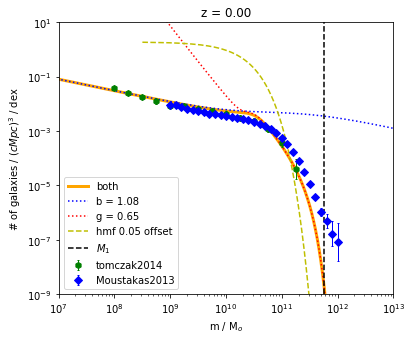

In [14]:
#playing around with the DPL params myself

fig, axs = pl.subplots(1, 1, figsize=(6, 5))

N = 0.01820
M_1 = 10**11.75 #np.exp(11.884)
beta = 1.08
gamma = 0.65

for i, z in enumerate([0]):
   
    data.PlotSMF(z=z, round_z=0.4, ax=axs)
    zz = np.argmin(np.abs(z - pop_halo.halos.tab_z))

    SMF, r = SMF_Moster2010(z, pop_halo, N, M_1, beta, gamma)

    SMFb, r1 = SMF_b(z, pop_halo, N, M_1, beta)
    SMFg, r2 = SMF_g(z, pop_halo, N, M_1, gamma)

    SM = 10**(r + np.log10(pop_halo.halos.tab_M))

    SM_b = 10**(r1 + np.log10(pop_halo.halos.tab_M))
    SM_g = 10**(r2 + np.log10(pop_halo.halos.tab_M))

    SM_h = np.linspace(10**8.5, 10**11.95, num=len(pop_halo.halos.tab_dndm[zz, :]))

    axs.loglog(SM, SMF, label='both', ls="-", linewidth=3, color="orange")
    axs.loglog(SM_b, SMFb, label='b = %.2f' %beta, ls=":", color="b") #why does this one basicly match the both model?
    axs.loglog(SM_g, SMFg, label='g = %.2f' %gamma, ls=":", color="r")
    
    axs.loglog(SM_h, pop_halo.halos.tab_dndm[zz, :], ls = "--", label='hmf 0.05 offset', color="y")

    axs.set_title("z = %.2f" %z)
    axs.set(xlabel='m / M$_o$', ylabel='# of galaxies / $ (cMpc)^3$ / dex')
    axs.axvline(M_1, color="black", label="$M_1$", ls = "--")
    axs.set_ylim(1e-9, 1e1)
#     axs[i].set_xlim(-35, 0)
    axs.legend()

pl.show()

### Higher redshift

# Shifting stellar masses by 0.25 dex (Chabrier -> Salpeter) for source=stefanon2017
# Shifting stellar masses by 0.25 dex (Chabrier -> Salpeter) for source=duncan2014


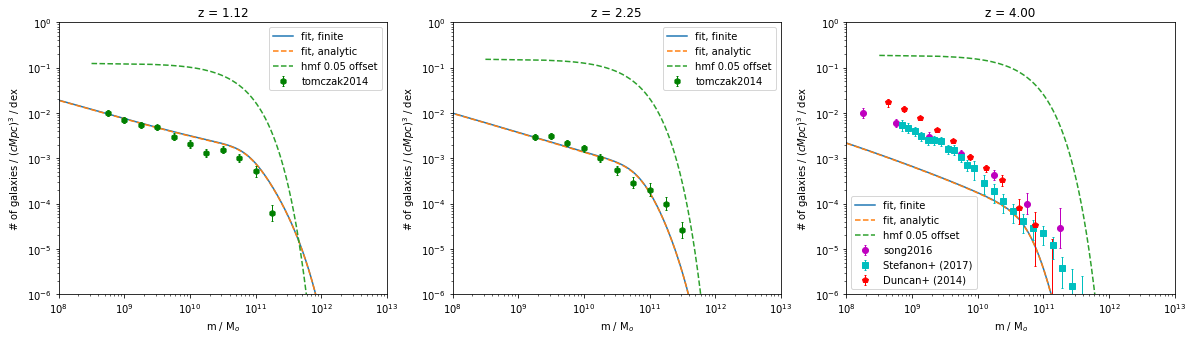

In [16]:
fig, axs = pl.subplots(1, 3, figsize=(20, 5))

#From Moster2010, table 7
logM_0 = 11.88 #(0.01)
mu = 0.019 #(0.002)
N_0 = 0.0282 #(0.0003)
nu = -0.72 #(0.06)
gamma_0 = 0.556 #0.001
gamma_1 = -0.26 #(0.05)
beta_0 = 1.06 #(0.06)
beta_1 = 0.17 #(0.12)

#we have data for [0.35, 0.875, 1.125, 1.75, 2.25, 2.75] currently

for i, z in enumerate([1.125, 2.25, 4]):
    #Redshift-dependent parameterizations
    N = N_0 * (z + 1)**nu
    M_1 = 10**(logM_0*(z+1)**mu)
    beta = beta_1*z+beta_0
    gamma = gamma_0*(z + 1)**gamma_1
    
#     print(N, M_1, beta, gamma)
   
    #plot lit values
    data.PlotSMF(z=z, round_z=0.2, ax=axs[i])
    
    #get z index for halo mass array
    zz = np.argmin(np.abs(z - pop_halo.halos.tab_z))
    
    SMF, r = SMF_Moster2010(z, pop_halo, N, M_1, beta, gamma, True)
    SMF_a, r = SMF_Moster2010(z, pop_halo, N, M_1, beta, gamma)

    #get new x axis coords in stellar mass
    Sm_off = np.linspace(10**8.5, 10**12.5, num=len(pop_halo.halos.tab_dndm[zz, :]))

    #using equ 2 to get the new stellar masses
    Sm = 10**(r + np.log10(pop_halo.halos.tab_M))[:-1]
    Sm_a = 10**(r + np.log10(pop_halo.halos.tab_M))

    #plotting
    axs[i].loglog(Sm, SMF, label='fit, finite')
    axs[i].loglog(Sm_a, SMF_a, label='fit, analytic', ls="--")
    
    #plotting just offset HMF for comparison
    axs[i].loglog(Sm_off, pop_halo.halos.tab_dndm[zz, :]*0.05, ls = "--", label='hmf 0.05 offset')

    axs[i].set_title("z = %.2f" %z)
    axs[i].set(xlabel='m / M$_o$', ylabel='# of galaxies / $ (cMpc)^3$ / dex')
    axs[i].set_ylim(1e-6, 1e0)
    axs[i].set_xlim(1e8, )
#     axs[i].axvline(10**(8.7), color="purple", label="Their lower limit-ish", ls=":")
    axs[i].legend()

pl.show()